## Shor's Algorithm
Shor’s algorithm is famous for factoring integers in polynomial time. Since the best-known classical algorithm requires superpolynomial time to factor the product of two primes, the widely used cryptosystem, RSA, relies on factoring being impossible for large enough integers.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


### The Problem: Period Finding 
Let’s look at the periodic function:

$f(x) = a^x\ mod\ N$

where $a$ and $N$ are positive integers,$a$ is less than $N$,and they have no common factors. The period, or order ( $r$ ), is the smallest (non-zero) integer such that:

$a^r\ mod\ N = 1$



### The Solution
The solution is to use Quantum Phase Estimation on the Unitary Operators
$U|y\rangle = |ay mod N\rangle$

we will solve the period finding problem for  
$a=7$ and $N=15$
 The function c_amod15 returns the controlled-U gate for a, repeated power times.

In [2]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [3]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

We also import the circuit for the QFT

In [4]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

With these building blocks we can easily construct the circuit for Shor's algorithm:

In [5]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold' 

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      ┌───┐│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

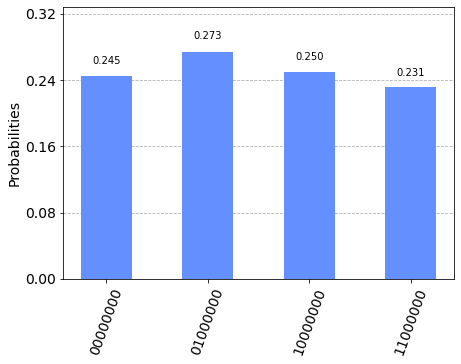

In [6]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

Since we have 3 qubits, these results correspond to measured phases of

In [7]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


We can now use the continued fractions algorithm to attempt to find s and r. 

In [8]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

Because this gives fractions that return the result exactly (in this case, 0.6660000...), this can give gnarly results like the one above. We can use the .limit_denominator() method to get the fraction that most closely resembles our float, with denominator below a certain value

In [9]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

 The order (r) must be less than N, so we will set the maximum denominator to be 15:

In [10]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


We can see that two of the measured eigenvalues provided us with the correct result:  
$r=4$
 , and we can see that Shor’s algorithm has a chance of failing. These bad results are because  
$s=0$
 , or because  
$s$
  and  
$r$
  are not coprime and instead of  $r$
  we are given a factor of  
$r$
 . The easiest solution to this is to simply repeat the experiment until we get a satisfying result for  
$r$
 